<a href="https://colab.research.google.com/github/Katlnkld/Autoencoders/blob/main/autoencoders_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders


# Часть 1. Vanilla Autoencoder

## 1.1. Подготовка данных


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize 
import skimage.io
%matplotlib inline
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
from torchsummary import summary

Зафиксируем рандомные состояния

In [ ]:
import random
import torch
import numpy as np
def set_seed(seed):
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Обучение на",device)

Обучение на cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs.astype('float')

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Количество изображений:

In [ ]:
len(data)

13143

In [ ]:
len(attrs)

13143

Изображения 64*64, 3 цветовых канала (RGB).

In [ ]:
data.shape

(13143, 64, 64, 3)

Посмотрим как выглядят картинки.

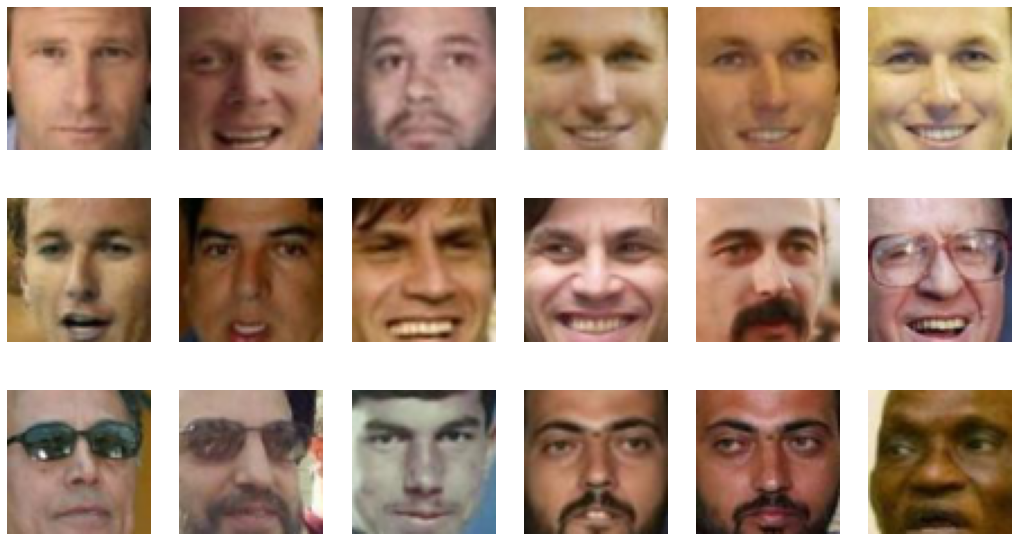

In [ ]:
plt.figure(figsize=(18, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])

plt.show()

Разбиение на train и val:

In [ ]:
data_train, data_val, attrs_train, attrs_val = train_test_split(data.astype('float32'), attrs ,test_size=0.2, shuffle=False)
print("Training input shape: ", data_train.shape)
print("Validating input shape: ", data_val.shape)

Training input shape:  (10514, 64, 64, 3)
Validating input shape:  (2629, 64, 64, 3)


In [ ]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=80)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=80)

## 1.2. Архитектура модели
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
latent_dim = 128 # размер латентного вектора

Реализуем autoencoder.

Методом проб и ошибок я подобрала модель, состоящую из двух сверточных слоев ( один из которых увеличивает количество каналов, а второй вдвое уменьшает изображение), и трех линейных слоев (два с активацией Relu, а после третьего выходит латентный слой).

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        
        
        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=0),
        )  
        
        self.flatten = nn.Flatten()
        
        self.fc_enc = nn.Sequential(  
            #nn.Flatten(),
            nn.Linear(64*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*32*32),
            #nn.Unflatten(1, *shapes),
        )
        self.unflatten = nn.Unflatten(1, torch.Size([64, 32, 32]))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
            #nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
        )


    def forward(self, x):
        shapes = x.shape
        #print('input',shapes)
        #print(x.permute(0,3,1,2).shape)
        x = self.encoder(x.permute(0,3,1,2))
        #print('conv', x.shape)
        x = self.flatten(x).float()
        #print('fc', x.shape)
        latent_code = self.fc_enc(x)
        #print('latent', latent_code.shape)

        y = self.fc_dec(latent_code)
        #print('fc2 =', y.shape)
        y = self.unflatten(y)
        #y = y.view(128,32,32)
        #print('out shapes', y.shape)
        reconstruction = self.decoder(y).permute(0,2,3,1)
        #print('reconst',reconstruction.shape)

        return torch.sigmoid(reconstruction), latent_code
    
    def sample(self, z):
        z = self.fc_dec(z)
        z = self.unflatten(z)
        generated = self.decoder(z).permute(0,2,3,1)
        return torch.sigmoid(generated)   

    def get_latent_vector(self, x):
        x = self.encoder(x.permute(0,3,1,2))
        x = self.flatten(x).float()
        latent_code = self.fc_enc(x)
        return latent_code 


In [ ]:
criterion = F.mse_loss
autoencoder = Autoencoder(input_size = 64*64*3, latent_dim = latent_dim).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001)

## 1.3 Обучение

In [ ]:
def train(model, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            reconstructed_train, _ = model(X_batch.to(device))
            loss = criterion(reconstructed_train, X_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_val in val_loader:
                reconstructed_val, _ = model(X_val.to(device))
                loss = criterion(reconstructed_val, X_val.to(device))
                val_losses_per_epoch.append(loss.item())
                
                reconstructed_val = reconstructed_val.cpu().detach().numpy()

        val_losses.append(np.mean(val_losses_per_epoch))

        # Прорисовка лиц после каждой эпохи
        clear_output(wait=True)
        plt.figure(figsize=(17, 5))
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val[k])
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructed_val[k])
            plt.title('Reconstructed')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(train_losses_per_epoch)))
        plt.show()
        
        # Отображение графиков лоссов после каждой эпохи

        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(epoch+1), train_losses, label='Train')
        plt.plot(np.arange(epoch+1), val_losses, label='Validation')

        #plt.ylim(0, 0.03)
        plt.xlim(0, n_epochs)
        plt.xlabel('Epoch')
        plt.title('MSE loss')
        plt.legend()
        plt.show()

    return train_losses, val_losses

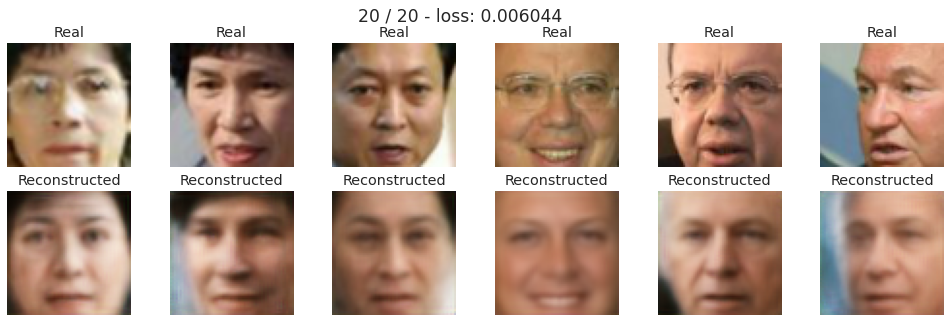

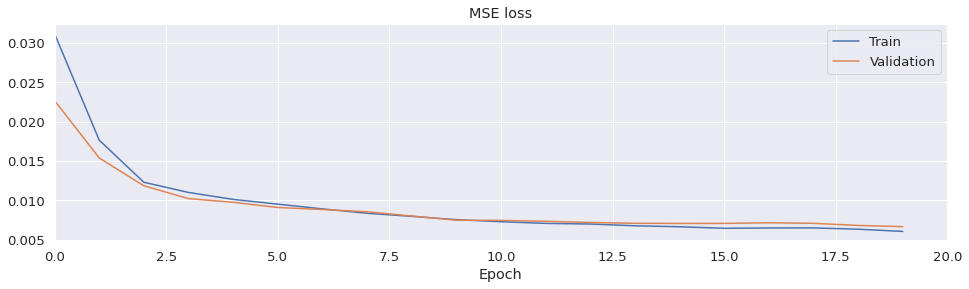

In [ ]:
info = train(autoencoder, 20)

In [ ]:
summary(autoencoder, input_size=(64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          16,448
           Flatten-4                [-1, 65536]               0
            Linear-5                 [-1, 1024]      67,109,888
              ReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 512]         524,800
              ReLU-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
           Linear-10                  [-1, 512]          66,048
             ReLU-11                  [-1, 512]               0
           Linear-12                 [-1, 1024]         525,312
             ReLU-13                 [-1, 1024]               0
           Linear-14                [-1

Видно, что модель неплохо реконструирует изображения людей, даже повтораяет цвет фона и наклон головы (положение в кадре). Черты лица похожи, однако очки модель распознать не может.

## 1.4. Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, latent_dim)
z = torch.FloatTensor(z).to(device)

Распределим рандомные векторы так же, как у реальных фото

In [ ]:
real_latent = autoencoder.get_latent_vector(torch.FloatTensor(data[:1000]).to(device))
print(real_latent.shape)

mu = real_latent.mean(dim=0)
print(mu.shape)

stdv = real_latent.std(dim=0)
print(stdv.shape)

z = z*stdv+mu

torch.Size([1000, 128])
torch.Size([128])
torch.Size([128])


In [ ]:
z = z*stdv+mu

In [ ]:
output = autoencoder.sample(z)# <скормим z декодеру>

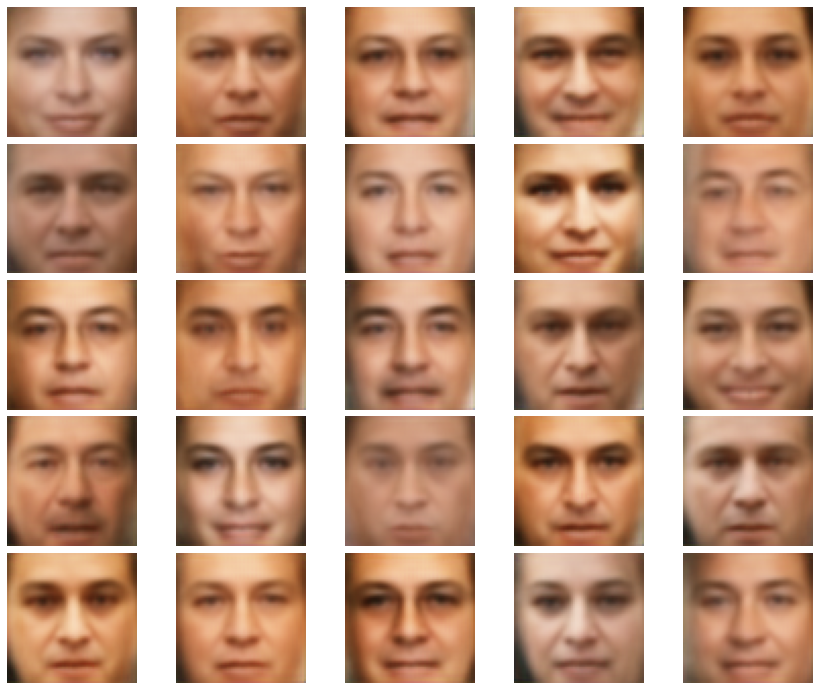

In [ ]:
plt.figure(figsize=(15, 30))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 5, i+1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)
  plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

Визуально получился хороший результат. Все получились разные, разный цвет кожи, пол, некоторые улыбаются.

## Time to make fun!

Научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Отсортируем датасет с аттрибутами по убыванию параметра улыбок и возьмем 100 человек с начала датасета (с улыбками) и с конца (с грустным лицом). Я взяла больше, чем предлагается в задании, потому что 15 самых улыбчивых людей в основном женского пола.

In [ ]:
attrs = attrs.sort_values(by=['Smiling'], ascending=False)
smile = data[attrs.head(100).index]
sad = data[attrs.tail(100).index]

Посмотрим на улыбающихся:

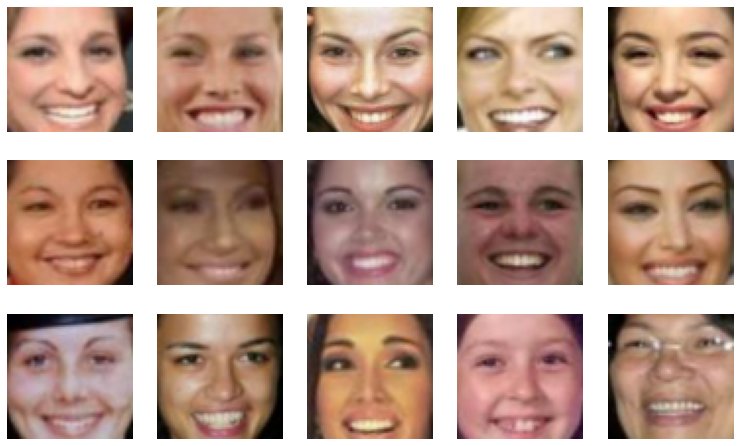

In [ ]:
plt.figure(figsize=(13, 8))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.imshow(smile[i])

plt.show()

И посмотрим на грустных:

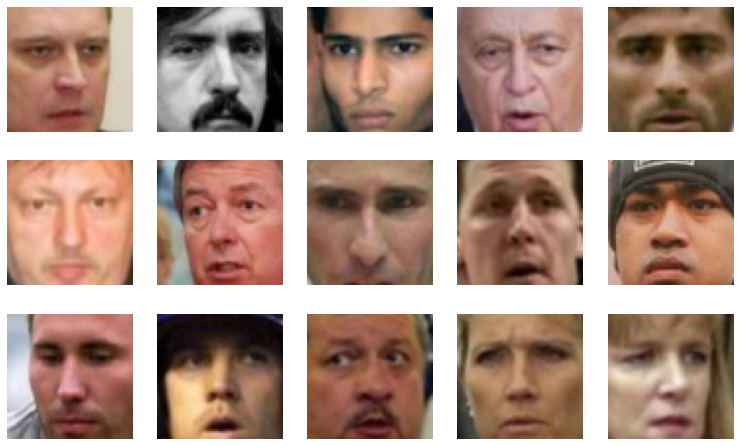

In [ ]:
plt.figure(figsize=(13, 8))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.imshow(sad[i])
plt.show()

In [ ]:
# Латентные вектора для улыбающихся людей
smile_latent_vector = autoencoder.get_latent_vector(torch.FloatTensor(smile).to(device))
# Латентные вектора для грусных людей
sad_latent_vector = autoencoder.get_latent_vector(torch.FloatTensor(sad).to(device))
# Вектор улыбки - разность средних латентных векторов
smile_vec = smile_latent_vector.mean(dim=0) - sad_latent_vector.mean(dim=0)
# Латентные вектора для грусных людей с прибавленным вектором улыбок
smiling_sad = sad_latent_vector + smile_vec

In [ ]:
smiling_sad.shape

torch.Size([100, 128])

In [ ]:
output = autoencoder.sample(smiling_sad.to(device))

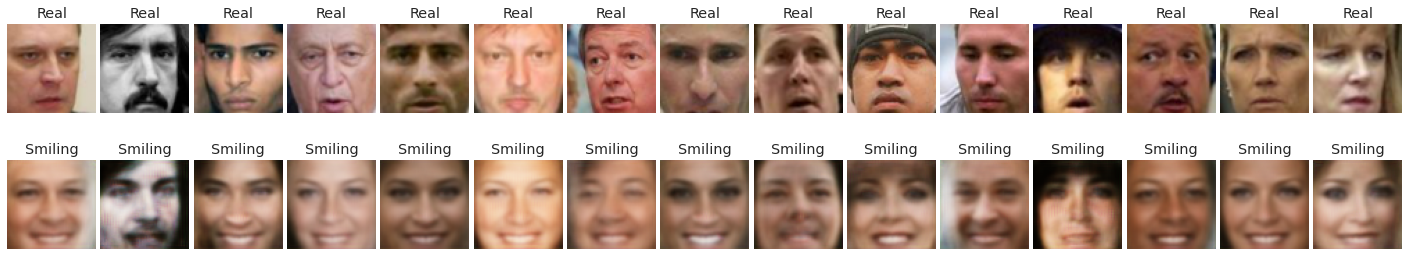

In [ ]:
output = autoencoder.sample(smiling_sad.to(device))
plt.figure(figsize=(25, 5))
for i in range(15):
    plt.subplot(2, 15, i+1)
    plt.imshow(sad[i])
    plt.title('Real')
    plt.axis('off')

    plt.subplot(2, 15, i+16)
    plt.imshow(output[i].cpu().detach().numpy())
    plt.title('Smiling')
    plt.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

В целом, заставить людей улыбаться удалось, однако некоторые мужчины стали женщинами. Я думаю, это произошло потому, что в выборке из 100 самых улыбающихся людей этого датасета в основном девушки.

Теперь можно пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Посмотрим, как выглядят цифры

In [ ]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

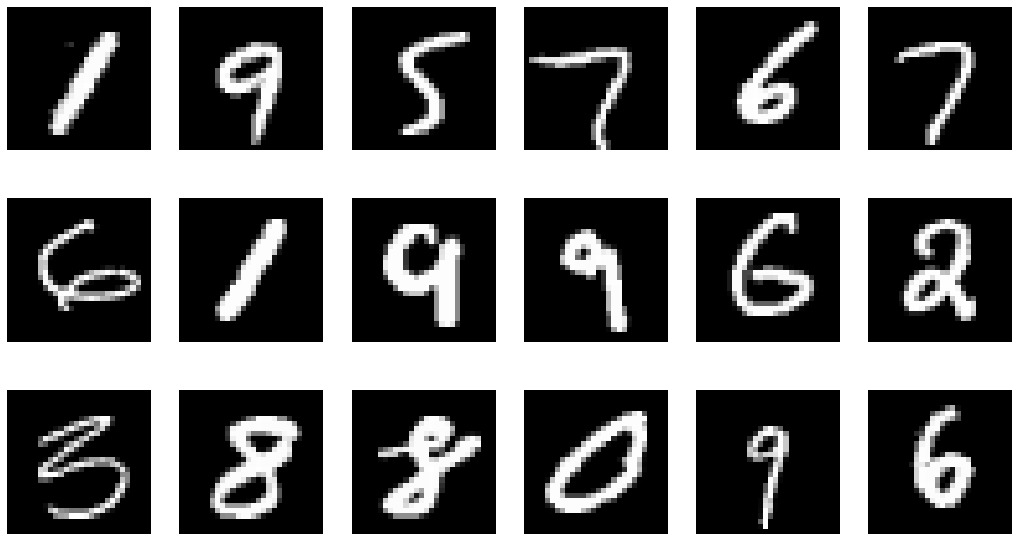

In [ ]:
plt.figure(figsize=(18, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap='gray')

plt.show()

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

Так как задача проще, чем предыдущая, я решила ограничиться только линейными слоями. Если ставить больше линейных слоев - то модель учится хуже, поэтому я остановилась на трех. Латентный вектор примем равный 16.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, dim_code):
        """
        <определим архитектуры encoder и decoder
        у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        """
        super().__init__()
        self.flatten = nn.Flatten()
        self.dim_code = dim_code
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, dim_code*2)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )  

    def encode(self, x):
        #<реализуйте forward проход энкодера, в качестве возвращаемых переменных -- mu и logsigma>
        x = self.flatten(x).float()
        x = self.encoder(x)
        mu, logsigma = torch.split(x, self.dim_code, dim=1)

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        shapes = x.shape
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        reconstruction = reconstruction.view(*shapes)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss =  -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE(input_size = 28*28, dim_code=16).to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001)

In [ ]:
def train(model, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, (X_batch, _) in enumerate(train_loader):
            #print(X_batch.shape)
            optimizer.zero_grad()
            reconstruction, mu, logsigma = model(X_batch.to(device))
            #print(reconstructed)
            loss = criterion( X_batch.to(device), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_val, _ in val_loader:
                reconstruction, mu, logsigma = model(X_val.to(device))
                loss = criterion(X_val.to(device),mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())
                
                reconstructed_val = reconstruction.cpu().detach().numpy()

        val_losses.append(np.mean(val_losses_per_epoch))
        
        # Прорисовка после каждой эпохи
        clear_output(wait=True)
        plt.figure(figsize=(20, 5))
        for k in range(10):
            plt.subplot(2, 10, k+1)
            plt.imshow(X_val[k].squeeze(), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow(reconstructed_val[k].squeeze(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(train_losses_per_epoch)))
        plt.show()
        
        # Отображение графиков лоссов после каждой эпохи

        plt.figure(figsize=(18, 4))
        plt.plot(np.arange(epoch+1), train_losses, label='Train')
        plt.plot(np.arange(epoch+1), val_losses, label='Validation')

        plt.xlim(0, n_epochs)
        plt.xlabel('Epoch')
        plt.title('VAE loss')
        plt.legend()
        plt.show()

    return train_losses, val_losses

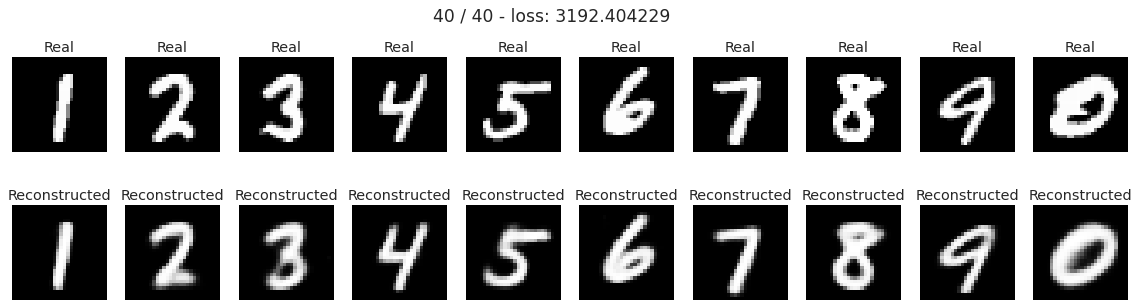

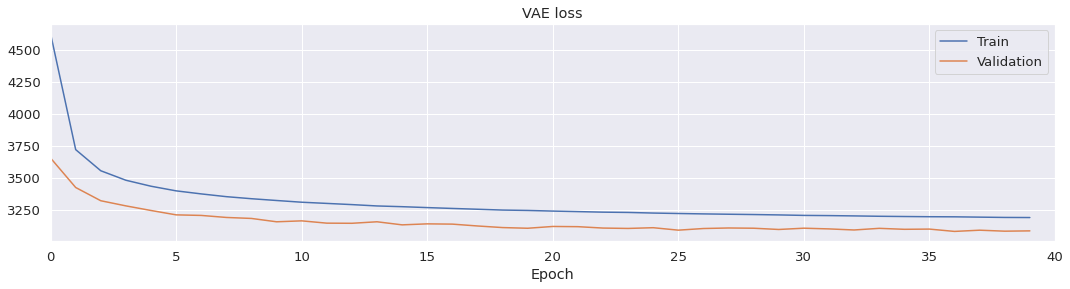

In [ ]:
info_vae = train(autoencoder, 40)

Тяжелее всего модель справлялася с тройкой: вплоть до 15 эпохи она рисовала ее как восьмерку, но потом сумела нормально обучиться.

Видно, что все цифры предсказаны четко и корректно.

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
dim_code=16

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
z = torch.FloatTensor(z).to(device)

In [ ]:
output = autoencoder.decode(z)# <скормите z декодеру>

In [ ]:
z.shape

torch.Size([10, 16])

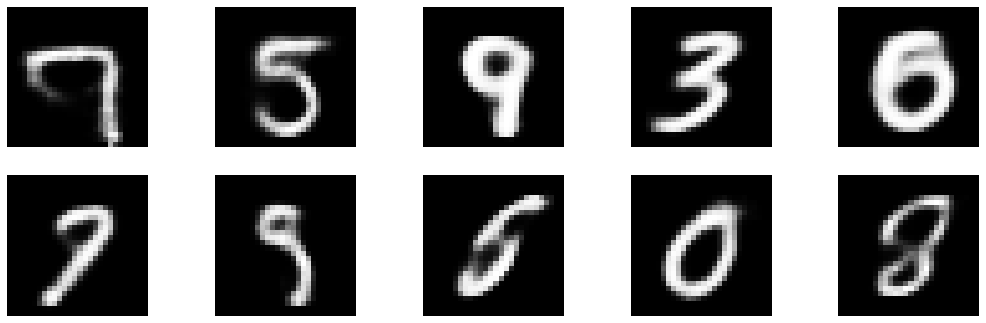

In [ ]:
plt.figure(figsize=(18, 15))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 2, 5, i+1)
    generated = output[i].view(-1, 1, 28, 28)
    generated = generated.cpu().detach().numpy()
    plt.imshow(generated.squeeze(), cmap='gray')
    plt.axis('off')
    
plt.show()

Здесь я не стала подгонять вектора, цифры и так получились читаемые.

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
def plot_latent(autoencoder):
    full_val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
    plt.figure(figsize=(12, 10))
    for i, (x, y) in enumerate(full_val_loader):
        z, _ = autoencoder.encode(x.to(device))
        z = z.cpu().detach().numpy()
    print(z.shape)
    
    z_embedded = TSNE(n_components=2, perplexity=30).fit_transform(z)
        
    fig = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y, cmap='tab10')
    plt.legend(*fig.legend_elements(), shadow=True, facecolor='white')
    plt.show()

(10000, 16)


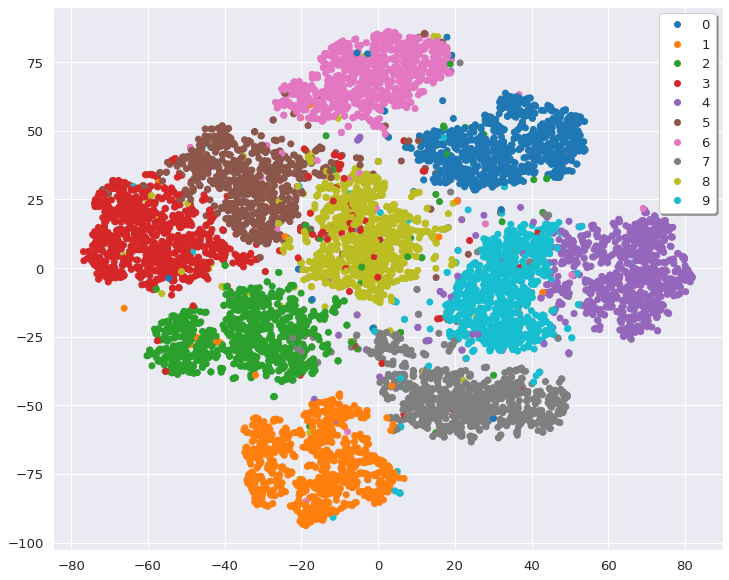

In [ ]:
plot_latent(autoencoder)

Если понизить размерность латентного вектора и отобразить на графике - видно, что латентные представления разных чисел разделены на отдельные кластеры (хоть и имеются некоторые выбросы). Это говорит о том, что модель хорошо справляется со своей задачей.

## 2.3. Conditional VAE


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
# Количество различных цифр для one-hot-encoding
cond_dim = train_loader.dataset.train_labels.unique().size(0)
cond_dim

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


10

Архитектуру возьмем такую же, как и для обычного VAE.

In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_size, latent_dim, cond_dim):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size+cond_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim*2)
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )  


    def encode(self, x, class_num):
        x = self.flatten(x).float()
        #print('x ', x.shape)
        #print('c ', class_num.shape)
        concat_input = torch.cat([x, class_num], 1)
        #print('outp', concat_input.shape)
        x = self.encoder(concat_input)
        #print(x.shape)
        mu, logsigma = torch.split(x, self.latent_dim, dim=1)
        #print(mu.shape)
        #print(logsigma.shape)
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) 
            eps = torch.randn_like(std) 
            sample = mu + (eps * std) 
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        concat_input = torch.cat([z, class_num], 1)
        #print('dec', concat_input.shape)
        reconstruction = self.decoder(concat_input)
        #print('rec', reconstruction.shape)
        reconstruction = torch.sigmoid(reconstruction)
        return reconstruction
    

    def forward(self, x, class_num):
        shapes = x.shape
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        reconstruction = reconstruction.view(*shapes)
        
        return reconstruction, mu, logsigma

In [ ]:
def train(model, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, (X_batch, label_batch) in enumerate(train_loader):
            #print(X_batch.shape)
            data, label = X_batch.to(device), F.one_hot(label_batch, num_classes=cond_dim).to(device)
            optimizer.zero_grad()
            reconstruction, mu, logsigma = model(data, label)
            #print(reconstructed)
            loss = criterion( data, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_val, label_val in val_loader:
                data, label = X_val.to(device), F.one_hot(label_val, num_classes=cond_dim).to(device) 
                reconstruction, mu, logsigma = model(data, label)
                loss = criterion(data, mu, logsigma, reconstruction)
                val_losses_per_epoch.append(loss.item())
                
                reconstructed_val = reconstruction.cpu().detach().numpy()

        val_losses.append(np.mean(val_losses_per_epoch))
        
        # Прорисовка после каждой эпохи
        clear_output(wait=True)
        plt.figure(figsize=(20, 5))
        for k in range(10):
            plt.subplot(2, 10, k+1)
            plt.imshow(X_val[k].squeeze(), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow(reconstructed_val[k].squeeze(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(train_losses_per_epoch)))
        plt.show()
        
        # Отображение графиков лоссов после каждой эпохи

        plt.figure(figsize=(18, 4))
        plt.plot(np.arange(epoch+1), train_losses, label='Train')
        plt.plot(np.arange(epoch+1), val_losses, label='Validation')

        #plt.ylim(0, 0.02)
        plt.xlim(0, n_epochs)
        plt.xlabel('Epoch')
        plt.title('VAE loss')
        plt.legend()
        plt.show()

    return train_losses, val_losses

In [ ]:
criterion = loss_vae

autoencoder = CVAE(input_size = 28*28, latent_dim=16, cond_dim=cond_dim ).to(device)

optimizer = torch.optim.AdamW(autoencoder.parameters())

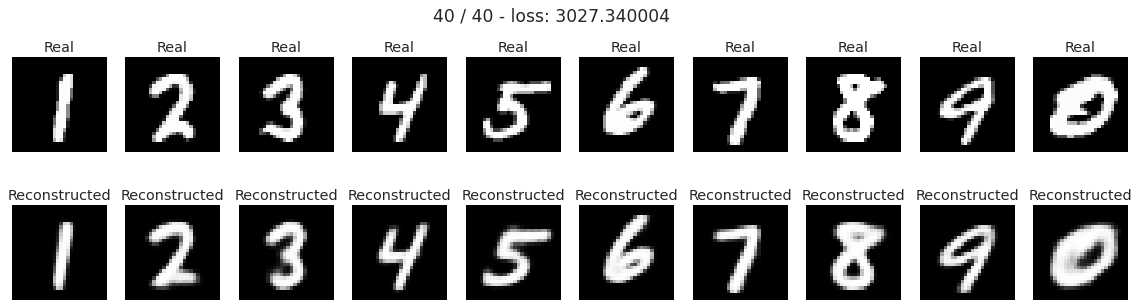

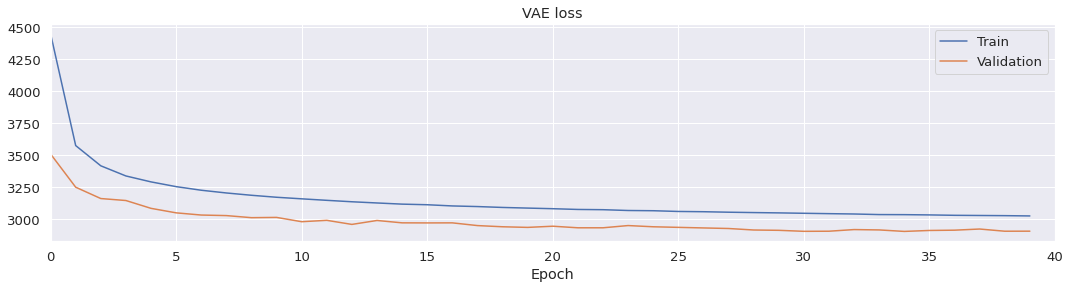

In [ ]:
info_vae = train(autoencoder, 40)

Цифры так же хорошо реконструируются, а лосс после 40 эпох получился даже чуть ниже, чем у обычного VAE.

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
latent_dim=16

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, latent_dim) for i in range(10)])
five =torch.FloatTensor([0,0,0,0,0,1,0,0,0,0]).expand(10,10)
seven =torch.FloatTensor([0,0,0,0,0,0,0,1,0,0]).expand(10,10)

In [ ]:
full_tr_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=True)
for i, (x, y) in enumerate(full_tr_loader):
    x, y = x.to(device), F.one_hot(y, num_classes=cond_dim).to(device)
    mu, stdv, _ = autoencoder.encode(x, y)

In [ ]:
mu = mu.mean(dim=0)

stdv = stdv.std(dim=0)

z = torch.FloatTensor(z).to(device)
z = z*stdv+mu

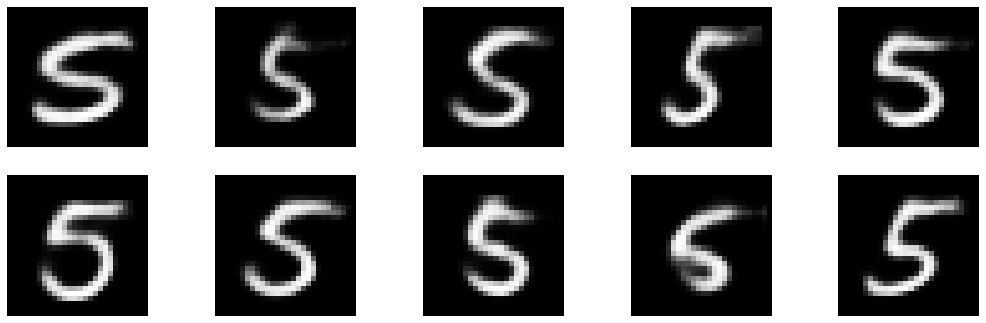

In [ ]:
output = autoencoder.decode(z, five.to(device))
plt.figure(figsize=(18, 15))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 2, 5, i+1)
    generated = output[i].view(-1, 1, 28, 28)
    generated = generated.cpu().detach().numpy()
    plt.imshow(generated.squeeze(), cmap='gray')
    plt.axis('off')
    
plt.show()

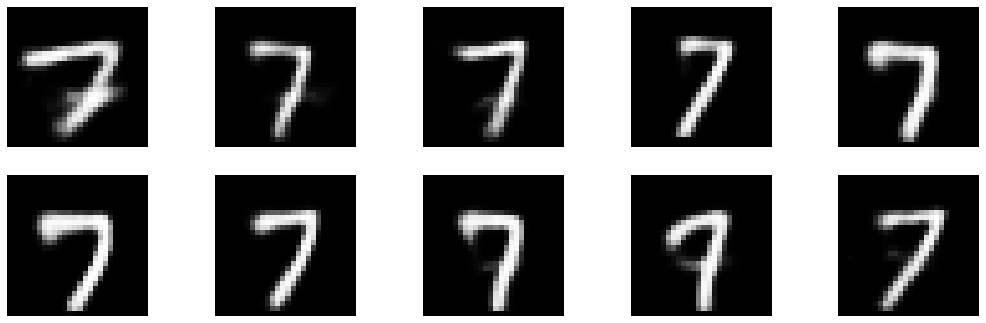

In [ ]:
output = autoencoder.decode(z, seven.to(device))
plt.figure(figsize=(18, 15))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 2, 5, i+1)
    generated = output[i].view(-1, 1, 28, 28)
    generated = generated.cpu().detach().numpy()
    plt.imshow(generated.squeeze(), cmap='gray')
    plt.axis('off')
    
plt.show()

Я проверила другие цифры, они тоже отображаются корректно.

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
def plot_latent(autoencoder):
    full_val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
    plt.figure(figsize=(12, 10))
    for i, (x, y) in enumerate(full_val_loader):
        x, y_hot = x.to(device), F.one_hot(y, num_classes=10).to(device)
        z, _ ,_ = autoencoder.encode(x,y_hot)
        z = z.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    z_embedded = TSNE(n_components=2, perplexity=30).fit_transform(z)    
    fig = plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y, cmap='tab10')
    plt.legend(*fig.legend_elements(), shadow=True, facecolor='white')
    plt.show()

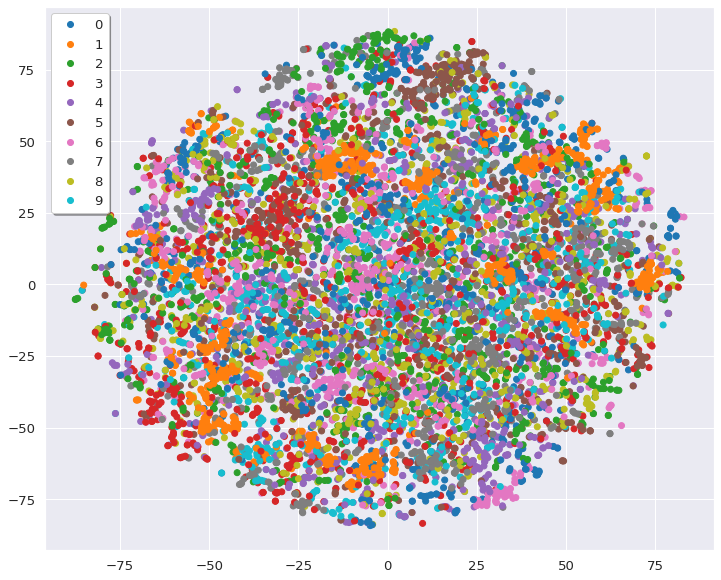

In [ ]:
plot_latent(autoencoder)

На двумерном изображении латентного пространства для CVAE невозможно выделить четкие кластеры изображений. CVAE не нухно разделять классы, так как они уже размечены. Латентное пространство скорее всего моделирует другие типы стилей: толщину, размер, наклон цифр и другие.

# Denoising

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
#X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
def train(model, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for i, X_batch in enumerate(train_loader):
            X_noisy = (X_batch + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_batch.shape)).to(torch.float32)
            #print(X_noisy)
            optimizer.zero_grad()
            reconstructed_train, _ = model(X_noisy.to(device))
            loss = criterion(reconstructed_train, X_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_val in val_loader:
                X_val_noisy = (X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape)).to(torch.float32)
                reconstructed_val, _ = model(X_val_noisy.to(device))
                loss = criterion(reconstructed_val, X_val.to(device))
                val_losses_per_epoch.append(loss.item())
                
                reconstructed_val = reconstructed_val.cpu().detach().numpy()

        val_losses.append(np.mean(val_losses_per_epoch))

        # Прорисовка лиц после каждой эпохи
        clear_output(wait=True)
        plt.figure(figsize=(17, 5))
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_noisy[k])
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(reconstructed_val[k])
            plt.title('Reconstructed')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, np.mean(train_losses_per_epoch)))
        plt.show()
        
        # Отображение графиков лоссов после каждой эпохи

        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(epoch+1), train_losses, label='Train')
        plt.plot(np.arange(epoch+1), val_losses, label='Validation')

        #plt.ylim(0, 0.03)
        plt.xlim(0, n_epochs)
        plt.xlabel('Epoch')
        plt.title('MSE loss')
        plt.legend()
        plt.show()

    return train_losses, val_losses

In [ ]:
criterion = F.mse_loss
autoencoder = Autoencoder(input_size = 64*64*3, latent_dim = 128).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


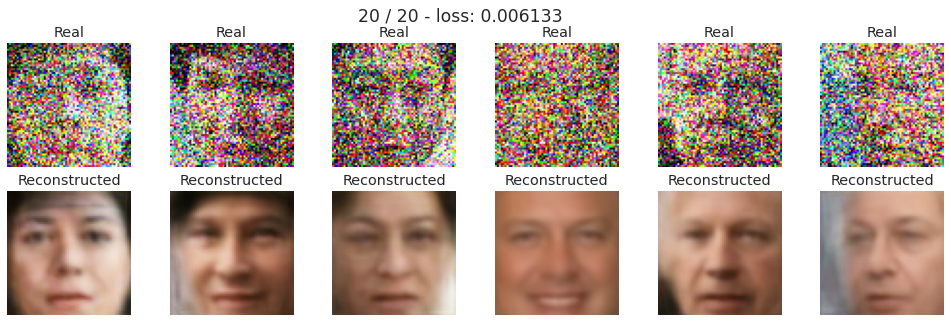

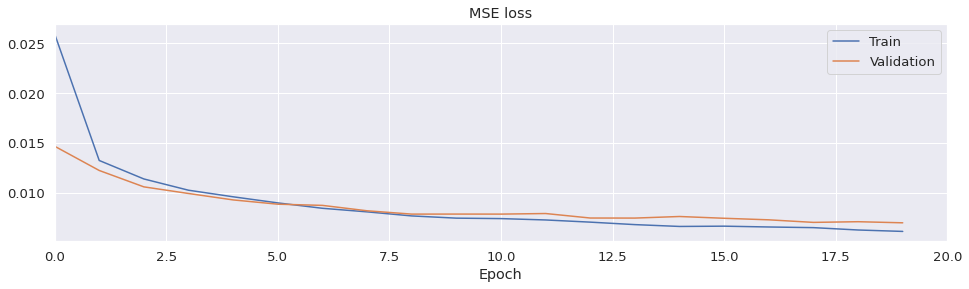

In [ ]:
info = train(autoencoder, 20)

Поставленная задача решена, на выходе получились изображения без шума.